In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from preprocess_retail import first_change, create_features_for_demand, create_features_by_customer
from tqdm import tqdm_notebook as tqdm
pd.set_option('display.max_columns', 500)

# Подготовка датасета

In [2]:
retail = pd.read_excel(r'D:\ML_Sets\online_retail_II.xlsx')

In [3]:
retail, features_for_demand = first_change(retail)

In [5]:

    
retail_by_day = create_features_for_demand(retail, features_for_demand )    

In [9]:
retail_by_day['Predict'] = retail_by_day['sum_sales'].shift(-1)

In [70]:
retail_by_day.head()

,10_hours,11_hours,12_hours,13_hours,14_hours,15_hours,16_hours,17_hours,18_hours,19_hours,20_hours,21_hours,7_hours,8_hours,9_hours,Australia,Australia_avg_sales,Australia_sales,Austria,Austria_avg_sales,Austria_sales,Avg_quantity,Bahrain,Bahrain_avg_sales,Bahrain_sales,Belgium,Belgium_avg_sales,Belgium_sales,Brazil,Brazil_avg_sales,Brazil_sales,Canada,Canada_avg_sales,Canada_sales,Channel Islands,Channel Islands_avg_sales,Channel Islands_sales,Cyprus,Cyprus_avg_sales,Cyprus_sales,Day,Denmark,Denmark_avg_sales,Denmark_sales,EIRE,EIRE_avg_sales,EIRE_sales,Fine price,Finland,Finland_avg_sales,Finland_sales,France,France_avg_sales,France_sales,Germany,Germany_avg_sales,Germany_sales,Greece,Greece_avg_sales,Greece_sales,High price,Iceland,Iceland_avg_sales,Iceland_sales,Israel,Israel_avg_sales,Israel_sales,Italy,Italy_avg_sales,Italy_sales,Japan,Japan_avg_sales,Japan_sales,Korea,Korea_avg_sales,Korea_sales,Lithuania,Lithuania_avg_sales,Lithuania_sales,Low price,Lowest price,Malta,Malta_avg_sales,Malta_sales,Month,Netherlands,Netherlands_avg_sales,Netherlands_sales,Nigeria,Nigeria_avg_sales,Nigeria_sales,Normal price,Norway,Norway_avg_sales,Norway_sales,Poland,Poland_avg_sales,Poland_sales,Portugal,Portugal_avg_sales,Portugal_sales,Quantity,RSA,RSA_avg_sales,RSA_sales,Singapore,Singapore_avg_sales,Singapore_sales,Spain,Spain_avg_sales,Spain_sales,Sweden,Sweden_avg_sales,Sweden_sales,Switzerland,Switzerland_avg_sales,Switzerland_sales,Thailand,Thailand_avg_sales,Thailand_sales,USA,USA_avg_sales,USA_sales,United Arab Emirates,United Arab Emirates_avg_sales,United Arab Emirates_sales,United Kingdom,United Kingdom_avg_sales,United Kingdom_sales,Unspecified,Unspecified_avg_sales,Unspecified_sales,West Indies,West Indies_avg_sales,West Indies_sales,avg_sale,count_customers,day_of_week,nunique_products,sum_sales,Predict
0,166,392.0,543.0,447.0,271,55.0,128.0,98.0,46.0,8.0,0.0,0.0,12.0,0.0,132.0,1.0,0.0,0.0,0.0,0.0,0.0,208.736842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,2009-12-01,0.0,0.0,0.0,2.0,1611.073430,3222.146860,406,0.0,0.0,0.0,3.0,548.352564,1645.057692,1.0,1345.403256,1345.403256,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,368,424,0.0,0.0,0.0,12,0.0,0.000000,0.000000,0.0,0.0,0.0,1094,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,3707.294304,3707.294304,23796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106,602.793890,63896.152361,0.0,0.0,0.0,0.0,0.0,0.0,651.583225,114,1,1061,74280.487676,89179.170560
1,231,356.0,455.0,409.0,186,367.0,148.0,36.0,0.0,0.0,0.0,0.0,0.0,13.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,301.673469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,2009-12-02,1.0,1008.0,1008.0,0.0,0.000000,0.000000,442,0.0,0.0,0.0,2.0,402.984815,805.969630,1.0,-23.000000,-23.000000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,1.0,-390.913333,-390.913333,0.0,0.0,0.0,0.0,0.0,0.0,376,454,0.0,0.0,0.0,12,1.0,8133.015652,8133.015652,0.0,0.0,0.0,1027,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,29564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92,830.142498,76373.109853,0.0,0.0,0.0,0.0,0.0,0.0,909.991536,98,2,1091,89179.170560,136406.478387
2,186,124.0,522.0,288.0,117,324.0,304.0,169.0,161.0,89.0,43.0,0.0,42.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,393.413793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,2009-12-03,0.0,0.0,0.0,1.0,1194.747273,1194.747273,446,0.0,0.0,0.0,2.0,-154.956667,-309.913333,1.0,-42.833333,-42.833333,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,432,443,0.0,0.0,0.0,12,0.0,0.000000,0.000000,0.0,0.0,0.0,1080,0.0,0.0,0.0,1.0,485.812727,485.812727,0.0,0.000000,0.000000,45636,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-3.3500,-3.3500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [51]:
retail_by_day.dropna(inplace=True)
X=retail_by_day.drop(['Predict', 'Day'], axis=1)
y =retail_by_day['Predict']

# Подбор параметров с помощью hyperopt.



In [ ]:
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, hp
from sklearn.metrics import mean_squared_error
# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.uniform('learning_rate',    0.005, 0.31, ),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'boosting_type':     'gbdt',
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.95),
    'subsample':        hp.uniform('subsample', 0.1, 1),
    'n_estimators':     1000,
    'gamma':            hp.uniform('gamma',     0.01, 0.95),
    'objective': 'reg:squarederror',
    'num_leaves':       hp.choice('num_leaves',        np.arange(600, 1200, 24, dtype=int)),               # 1024,440    # 2^max_depth < num_leaves ?
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0.01, 0.25),
    'min_child_weight':  hp.uniform('min_child_weight', 0.1, 3),
    'lambda_l1':        hp.uniform('l1', 0, 3),
    'lambda_l2':        hp.uniform('l2', 0, 3),
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 100,
    'verbose': False,
    
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.uniform('learning_rate',    0.005, 0.31, ),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 20, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.uniform('colsample_bytree',0.1, 0.9),
    'subsample':        hp.uniform('subsample', 0.1, 1),
    'n_estimators':     1000,
    'boosting_type':      'gbdt', 
    'objective': 'regression',
    'metric': 'rmse',
    'feature_fraction':  hp.uniform('feature_fraction', 0.1, 0.99),       
    'bagging_fraction':  hp.uniform('bagging_fraction', 0.1, 0.95),       
    'gamma':            hp.uniform('gamma',     0.01, 0.5),
  
    'num_leaves':       hp.choice('num_leaves',        np.arange(900, 1200, 24, dtype=int)),              
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0.01, 0.25),
    'min_child_weight':  hp.uniform('min_child_weight', 0.1, 3),
    'lambda_l1':        hp.uniform('l1', 1, 3),
    'lambda_l2':        hp.uniform('l2', 1, 3),
}
lgb_fit_params = {
    #'eval_metric': 'l2',
    #'verbose_eval ': 50,
    'early_stopping_rounds': 100,
    'verbose': False,

   
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 16, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      1000,
    'eval_metric':       'RMSE',
}
ctb_fit_params = {
    'early_stopping_rounds': 100,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


In [45]:
obj = HPOpt(X.iloc[:-50], X.iloc[-50:], y.iloc[:-50], y.iloc[-50:])

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=300)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=300)


  0%|                                  | 0/300 [00:00<?, ?trial/s, best loss=?]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  0%|        | 1/300 [00:00<02:05,  2.39trial/s, best loss: 31569.009719315553]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  1%|         | 2/300 [00:00<02:11,  2.27trial/s, best loss: 30283.97048146158]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  1%|         | 3/300 [00:01<02:30,  1.97trial/s, best loss: 28729.37885747432]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  1%|         | 4/300 [00:02<02:41,  1.84trial/s, best loss: 27771.89519774295]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  2%|▏        | 5/300 [00:03<04:13,  1.16trial/s, best loss: 27771.89519774295]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  2%|▏        | 6/300 [00:04<03:19,  1.47trial/s, best loss: 27771.89519774295]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  2%|▏        | 7/300 [00:04<03:09,  1.55trial/s, best loss: 27771.89519774295]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  3%|▏        | 8/300 [00:04<02:38,  1.85trial/s, best loss: 27771.89519774295]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  3%|▏       | 9/300 [00:05<02:21,  2.06trial/s, best loss: 27502.654577209672]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  3%|▎       | 10/300 [00:05<02:17,  2.11trial/s, best loss: 27483.45236162288]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  4%|▎       | 11/300 [00:07<04:33,  1.06trial/s, best loss: 27483.45236162288]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  4%|▎       | 12/300 [00:08<03:59,  1.20trial/s, best loss: 27483.45236162288]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  4%|▎       | 13/300 [00:08<03:05,  1.55trial/s, best loss: 27483.45236162288]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  5%|▎       | 14/300 [00:09<02:52,  1.66trial/s, best loss: 27483.45236162288]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  5%|▍       | 15/300 [00:09<02:28,  1.92trial/s, best loss: 27483.45236162288]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  5%|▎      | 16/300 [00:09<02:31,  1.87trial/s, best loss: 27281.364241374857]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  6%|▍      | 17/300 [00:10<02:13,  2.12trial/s, best loss: 27281.364241374857]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  6%|▍      | 18/300 [00:10<02:20,  2.01trial/s, best loss: 27281.364241374857]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  6%|▍      | 19/300 [00:11<02:02,  2.30trial/s, best loss: 27281.364241374857]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  7%|▍      | 20/300 [00:11<01:54,  2.45trial/s, best loss: 27281.364241374857]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  7%|▍      | 21/300 [00:11<01:55,  2.42trial/s, best loss: 27281.364241374857]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  7%|▌      | 22/300 [00:12<02:01,  2.29trial/s, best loss: 27281.364241374857]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  8%|▌      | 23/300 [00:12<02:01,  2.28trial/s, best loss: 27281.364241374857]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  8%|▌      | 24/300 [00:13<02:04,  2.21trial/s, best loss: 27281.364241374857]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  8%|▌      | 25/300 [00:13<01:57,  2.33trial/s, best loss: 27281.364241374857]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  9%|▌      | 26/300 [00:14<02:08,  2.14trial/s, best loss: 27281.364241374857]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  9%|▋      | 27/300 [00:14<02:08,  2.12trial/s, best loss: 27281.364241374857]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



  9%|▋      | 28/300 [00:15<02:06,  2.15trial/s, best loss: 27281.364241374857]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 10%|▊       | 29/300 [00:15<01:59,  2.27trial/s, best loss: 25939.88129639299]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 10%|▊       | 30/300 [00:15<01:41,  2.67trial/s, best loss: 25939.88129639299]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 10%|▊       | 31/300 [00:16<01:33,  2.88trial/s, best loss: 25939.88129639299]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 11%|▋      | 32/300 [00:16<01:45,  2.53trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 11%|▊      | 33/300 [00:17<01:50,  2.42trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 11%|▊      | 34/300 [00:17<01:50,  2.41trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 12%|▊      | 35/300 [00:17<01:48,  2.44trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 12%|▊      | 36/300 [00:18<02:27,  1.79trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 12%|▊      | 37/300 [00:19<02:38,  1.66trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 13%|▉      | 38/300 [00:19<02:13,  1.96trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 13%|▉      | 39/300 [00:20<02:07,  2.04trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 13%|▉      | 40/300 [00:20<02:09,  2.01trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 14%|▉      | 41/300 [00:21<02:18,  1.86trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 14%|▉      | 42/300 [00:21<02:03,  2.08trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 14%|█      | 43/300 [00:22<01:52,  2.29trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 15%|█      | 44/300 [00:22<01:51,  2.30trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 15%|█      | 45/300 [00:23<02:38,  1.61trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 15%|█      | 46/300 [00:23<02:21,  1.79trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 16%|█      | 47/300 [00:24<02:49,  1.50trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 16%|█      | 48/300 [00:25<02:25,  1.74trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 16%|█▏     | 49/300 [00:25<02:17,  1.83trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 17%|█▏     | 50/300 [00:25<01:59,  2.10trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 17%|█▏     | 51/300 [00:26<02:29,  1.66trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 17%|█▏     | 52/300 [00:27<02:22,  1.74trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 18%|█▏     | 53/300 [00:27<02:14,  1.84trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 18%|█▎     | 54/300 [00:28<01:54,  2.14trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 18%|█▎     | 55/300 [00:28<01:46,  2.31trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 19%|█▎     | 56/300 [00:28<01:44,  2.32trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 19%|█▎     | 57/300 [00:29<01:56,  2.08trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 19%|█▎     | 58/300 [00:30<02:04,  1.94trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 20%|█▍     | 59/300 [00:30<02:04,  1.94trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 20%|█▍     | 60/300 [00:31<02:00,  1.99trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 20%|█▍     | 61/300 [00:31<02:00,  1.98trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 21%|█▍     | 62/300 [00:32<02:09,  1.84trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 21%|█▍     | 63/300 [00:32<02:07,  1.86trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 21%|█▍     | 64/300 [00:33<01:54,  2.05trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 22%|█▌     | 65/300 [00:33<01:41,  2.31trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 22%|█▌     | 66/300 [00:34<02:35,  1.51trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 22%|█▌     | 67/300 [00:35<03:06,  1.25trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 23%|█▌     | 68/300 [00:36<03:12,  1.21trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 23%|█▌     | 69/300 [00:38<03:50,  1.00trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 23%|█▋     | 70/300 [00:38<03:35,  1.07trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 24%|█▋     | 71/300 [00:39<03:20,  1.14trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 24%|█▋     | 72/300 [00:40<03:32,  1.07trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 24%|█▋     | 73/300 [00:41<03:26,  1.10trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 25%|█▋     | 74/300 [00:42<03:51,  1.02s/trial, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 25%|█▊     | 75/300 [00:43<03:31,  1.06trial/s, best loss: 25451.811756079187]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 25%|██      | 76/300 [00:44<03:21,  1.11trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 26%|██      | 77/300 [00:45<03:47,  1.02s/trial, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 26%|██      | 78/300 [00:46<03:10,  1.16trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 26%|██      | 79/300 [00:46<02:34,  1.43trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 27%|██▏     | 80/300 [00:46<02:20,  1.56trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 27%|██▏     | 81/300 [00:47<01:57,  1.87trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 27%|██▏     | 82/300 [00:47<01:57,  1.86trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 28%|██▏     | 83/300 [00:48<01:44,  2.08trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 28%|██▏     | 84/300 [00:48<01:36,  2.25trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 28%|██▎     | 85/300 [00:48<01:27,  2.46trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 29%|██▎     | 86/300 [00:49<01:22,  2.59trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 29%|██▎     | 87/300 [00:49<01:45,  2.02trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 29%|██▎     | 88/300 [00:50<02:07,  1.66trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 30%|██▎     | 89/300 [00:51<01:59,  1.77trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 30%|██▍     | 90/300 [00:51<01:48,  1.94trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 30%|██▍     | 91/300 [00:52<01:41,  2.05trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 31%|██▍     | 92/300 [00:52<01:28,  2.35trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 31%|██▍     | 93/300 [00:52<01:21,  2.54trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 31%|██▌     | 94/300 [00:53<01:38,  2.08trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 32%|██▌     | 95/300 [00:54<01:50,  1.86trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 32%|██▌     | 96/300 [00:54<01:57,  1.73trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 32%|██▌     | 97/300 [00:55<01:44,  1.94trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 33%|██▌     | 98/300 [00:55<01:38,  2.04trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 33%|██▋     | 99/300 [00:55<01:29,  2.25trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 33%|██▎    | 100/300 [00:56<01:17,  2.59trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 34%|██▎    | 101/300 [00:56<01:25,  2.32trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 34%|██▍    | 102/300 [00:57<02:04,  1.59trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 34%|██▍    | 103/300 [00:58<02:05,  1.57trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 35%|██▍    | 104/300 [01:00<03:50,  1.17s/trial, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 35%|██▍    | 105/300 [01:01<02:55,  1.11trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 35%|██▍    | 106/300 [01:01<02:26,  1.33trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 36%|██▍    | 107/300 [01:02<02:47,  1.15trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 36%|██▌    | 108/300 [01:03<02:35,  1.23trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 36%|██▌    | 109/300 [01:03<02:18,  1.37trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 37%|██▌    | 110/300 [01:04<01:59,  1.59trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 37%|██▌    | 111/300 [01:04<01:46,  1.77trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 37%|██▌    | 112/300 [01:05<01:43,  1.82trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 38%|██▋    | 113/300 [01:05<01:59,  1.57trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 38%|██▋    | 114/300 [01:06<01:55,  1.60trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 38%|██▋    | 115/300 [01:07<01:51,  1.66trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 39%|██▋    | 116/300 [01:07<01:33,  1.96trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 39%|██▋    | 117/300 [01:07<01:27,  2.09trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 39%|██▊    | 118/300 [01:08<01:18,  2.33trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 40%|██▊    | 119/300 [01:08<01:08,  2.65trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 40%|██▊    | 120/300 [01:08<01:14,  2.41trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 40%|██▊    | 121/300 [01:09<01:23,  2.14trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 41%|██▊    | 122/300 [01:09<01:15,  2.34trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 41%|██▊    | 123/300 [01:10<01:21,  2.18trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 41%|██▉    | 124/300 [01:10<01:16,  2.30trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 42%|██▉    | 125/300 [01:11<01:16,  2.29trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 42%|██▉    | 126/300 [01:11<01:12,  2.41trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 42%|██▉    | 127/300 [01:12<01:15,  2.29trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 43%|██▉    | 128/300 [01:12<01:35,  1.79trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 43%|███    | 129/300 [01:13<01:19,  2.15trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 43%|███    | 130/300 [01:13<01:09,  2.45trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 44%|███    | 131/300 [01:13<01:14,  2.27trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 44%|███    | 132/300 [01:14<01:41,  1.65trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 44%|███    | 133/300 [01:15<02:00,  1.38trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 45%|███▏   | 134/300 [01:16<01:50,  1.50trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 45%|███▏   | 135/300 [01:17<01:53,  1.45trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 45%|███▏   | 136/300 [01:17<01:51,  1.46trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 46%|███▏   | 137/300 [01:18<01:52,  1.45trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 46%|███▏   | 138/300 [01:20<03:05,  1.15s/trial, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 46%|███▏   | 139/300 [01:21<02:47,  1.04s/trial, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 47%|███▎   | 140/300 [01:22<02:47,  1.05s/trial, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 47%|███▎   | 141/300 [01:23<02:27,  1.07trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 47%|███▎   | 142/300 [01:23<02:06,  1.25trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 48%|███▎   | 143/300 [01:24<01:51,  1.41trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 48%|███▎   | 144/300 [01:25<01:53,  1.37trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 48%|███▍   | 145/300 [01:26<02:04,  1.25trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 49%|███▍   | 146/300 [01:26<01:45,  1.46trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 49%|███▍   | 147/300 [01:26<01:31,  1.67trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 49%|███▍   | 148/300 [01:27<01:27,  1.74trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 50%|███▍   | 149/300 [01:27<01:18,  1.93trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 50%|███▌   | 150/300 [01:28<01:15,  1.99trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 50%|███▌   | 151/300 [01:28<01:14,  2.01trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 51%|███▌   | 152/300 [01:29<01:20,  1.83trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 51%|███▌   | 153/300 [01:30<02:00,  1.22trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 51%|███▌   | 154/300 [01:31<01:37,  1.49trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 52%|███▌   | 155/300 [01:31<01:28,  1.65trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 52%|███▋   | 156/300 [01:32<01:29,  1.60trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 52%|███▋   | 157/300 [01:33<01:39,  1.44trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 53%|███▋   | 158/300 [01:33<01:33,  1.52trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 53%|███▋   | 159/300 [01:34<01:26,  1.63trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 53%|███▋   | 160/300 [01:34<01:17,  1.80trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 54%|███▊   | 161/300 [01:35<01:22,  1.68trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 54%|███▊   | 162/300 [01:36<01:34,  1.47trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 54%|███▊   | 163/300 [01:36<01:27,  1.57trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 55%|███▊   | 164/300 [01:37<01:15,  1.80trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 55%|███▊   | 165/300 [01:38<01:57,  1.15trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 55%|███▊   | 166/300 [01:38<01:35,  1.41trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 56%|███▉   | 167/300 [01:39<01:19,  1.67trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 56%|███▉   | 168/300 [01:40<01:35,  1.38trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 56%|███▉   | 169/300 [01:40<01:30,  1.45trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 57%|███▉   | 170/300 [01:41<01:13,  1.77trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 57%|███▉   | 171/300 [01:41<01:18,  1.65trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 57%|████   | 172/300 [01:42<01:08,  1.86trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 58%|████   | 173/300 [01:42<00:59,  2.12trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 58%|████   | 174/300 [01:42<00:53,  2.36trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 58%|████   | 175/300 [01:43<00:53,  2.35trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 59%|████   | 176/300 [01:44<01:03,  1.96trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 59%|████▏  | 177/300 [01:45<01:50,  1.11trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 59%|████▏  | 178/300 [01:46<01:50,  1.10trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 60%|████▏  | 179/300 [01:47<01:35,  1.26trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 60%|████▏  | 180/300 [01:47<01:28,  1.36trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 60%|████▏  | 181/300 [01:48<01:12,  1.65trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 61%|████▏  | 182/300 [01:48<01:07,  1.74trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 61%|████▎  | 183/300 [01:49<00:58,  2.00trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 61%|████▎  | 184/300 [01:49<00:53,  2.18trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 62%|████▎  | 185/300 [01:49<00:49,  2.31trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 62%|████▎  | 186/300 [01:50<00:55,  2.07trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 62%|████▎  | 187/300 [01:51<01:00,  1.85trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 63%|████▍  | 188/300 [01:53<02:01,  1.09s/trial, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 63%|████▍  | 189/300 [01:53<01:32,  1.20trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 63%|████▍  | 190/300 [01:54<01:25,  1.29trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 64%|████▍  | 191/300 [01:55<01:27,  1.24trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 64%|████▍  | 192/300 [01:55<01:13,  1.46trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 64%|████▌  | 193/300 [01:56<01:08,  1.55trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 65%|████▌  | 194/300 [01:56<01:04,  1.65trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 65%|████▌  | 195/300 [01:57<01:05,  1.60trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 65%|████▌  | 196/300 [01:57<01:06,  1.56trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 66%|████▌  | 197/300 [01:58<01:03,  1.62trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 66%|████▌  | 198/300 [01:59<01:02,  1.64trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 66%|████▋  | 199/300 [01:59<01:03,  1.58trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 67%|████▋  | 200/300 [02:00<01:06,  1.51trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 67%|████▋  | 201/300 [02:01<01:04,  1.53trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 67%|████▋  | 202/300 [02:01<01:01,  1.59trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 68%|████▋  | 203/300 [02:02<01:02,  1.55trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 68%|████▊  | 204/300 [02:03<01:06,  1.44trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 68%|████▊  | 205/300 [02:03<01:00,  1.56trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 69%|████▊  | 206/300 [02:04<01:03,  1.47trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 69%|████▊  | 207/300 [02:05<01:03,  1.47trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 69%|████▊  | 208/300 [02:05<00:58,  1.57trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 70%|████▉  | 209/300 [02:06<00:55,  1.63trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 70%|████▉  | 210/300 [02:07<00:58,  1.54trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 70%|████▉  | 211/300 [02:07<01:00,  1.48trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 71%|████▉  | 212/300 [02:08<01:05,  1.34trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 71%|████▉  | 213/300 [02:09<00:56,  1.54trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 71%|████▉  | 214/300 [02:10<01:02,  1.37trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 72%|█████  | 215/300 [02:10<00:52,  1.61trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 72%|█████  | 216/300 [02:11<00:52,  1.61trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 72%|█████  | 217/300 [02:11<00:54,  1.53trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 73%|█████  | 218/300 [02:12<00:51,  1.58trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 73%|█████  | 219/300 [02:12<00:45,  1.79trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 73%|█████▏ | 220/300 [02:13<00:47,  1.70trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 74%|█████▏ | 221/300 [02:13<00:45,  1.72trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 74%|█████▏ | 222/300 [02:14<00:50,  1.55trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 74%|█████▏ | 223/300 [02:15<00:49,  1.57trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 75%|█████▏ | 224/300 [02:15<00:45,  1.67trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 75%|█████▎ | 225/300 [02:16<00:47,  1.57trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 75%|█████▎ | 226/300 [02:16<00:40,  1.84trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 76%|█████▎ | 227/300 [02:17<00:38,  1.90trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 76%|█████▎ | 228/300 [02:17<00:35,  2.04trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 76%|█████▎ | 229/300 [02:18<00:34,  2.03trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 77%|█████▎ | 230/300 [02:19<00:38,  1.80trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 77%|█████▍ | 231/300 [02:19<00:37,  1.83trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 77%|█████▍ | 232/300 [02:20<00:42,  1.61trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 78%|█████▍ | 233/300 [02:20<00:41,  1.62trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 78%|█████▍ | 234/300 [02:21<00:45,  1.45trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 78%|█████▍ | 235/300 [02:22<00:41,  1.56trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 79%|█████▌ | 236/300 [02:23<00:45,  1.40trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 79%|█████▌ | 237/300 [02:23<00:37,  1.66trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 79%|█████▌ | 238/300 [02:24<00:35,  1.73trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 80%|█████▌ | 239/300 [02:24<00:33,  1.81trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 80%|█████▌ | 240/300 [02:25<00:36,  1.64trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 80%|█████▌ | 241/300 [02:25<00:30,  1.93trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 81%|█████▋ | 242/300 [02:26<00:37,  1.55trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 81%|█████▋ | 243/300 [02:27<00:34,  1.64trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 81%|█████▋ | 244/300 [02:27<00:37,  1.51trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 82%|█████▋ | 245/300 [02:28<00:33,  1.65trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 82%|█████▋ | 246/300 [02:29<00:33,  1.60trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 82%|█████▊ | 247/300 [02:29<00:33,  1.60trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 83%|█████▊ | 248/300 [02:30<00:32,  1.62trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 83%|█████▊ | 249/300 [02:30<00:28,  1.76trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 83%|█████▊ | 250/300 [02:31<00:34,  1.47trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 84%|█████▊ | 251/300 [02:32<00:28,  1.71trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 84%|█████▉ | 252/300 [02:32<00:25,  1.91trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 84%|█████▉ | 253/300 [02:33<00:29,  1.62trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 85%|█████▉ | 254/300 [02:33<00:24,  1.88trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 85%|█████▉ | 255/300 [02:34<00:24,  1.81trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 85%|█████▉ | 256/300 [02:34<00:22,  1.96trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 86%|█████▉ | 257/300 [02:35<00:22,  1.93trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 86%|██████ | 258/300 [02:35<00:24,  1.71trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 86%|██████ | 259/300 [02:36<00:29,  1.41trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 87%|██████ | 260/300 [02:38<00:38,  1.03trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 87%|██████ | 261/300 [02:39<00:36,  1.08trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 87%|██████ | 262/300 [02:40<00:38,  1.02s/trial, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 88%|██████▏| 263/300 [02:41<00:34,  1.09trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 88%|██████▏| 264/300 [02:41<00:29,  1.22trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 88%|██████▏| 265/300 [02:43<00:33,  1.06trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 89%|██████▏| 266/300 [02:43<00:28,  1.18trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 89%|██████▏| 267/300 [02:44<00:29,  1.13trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 89%|██████▎| 268/300 [02:45<00:25,  1.23trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 90%|██████▎| 269/300 [02:47<00:38,  1.25s/trial, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 90%|██████▎| 270/300 [02:47<00:30,  1.01s/trial, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 90%|██████▎| 271/300 [02:48<00:25,  1.15trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 91%|██████▎| 272/300 [02:48<00:21,  1.33trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 91%|██████▎| 273/300 [02:49<00:19,  1.41trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 91%|██████▍| 274/300 [02:49<00:15,  1.64trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 92%|██████▍| 275/300 [02:50<00:13,  1.84trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 92%|██████▍| 276/300 [02:50<00:11,  2.02trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 92%|██████▍| 277/300 [02:51<00:12,  1.80trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 93%|██████▍| 278/300 [02:52<00:13,  1.59trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 93%|██████▌| 279/300 [02:52<00:12,  1.73trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 93%|██████▌| 280/300 [02:53<00:14,  1.36trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 94%|██████▌| 281/300 [02:54<00:12,  1.56trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 94%|██████▌| 282/300 [02:54<00:10,  1.74trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 94%|██████▌| 283/300 [02:55<00:09,  1.88trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 95%|██████▋| 284/300 [02:55<00:08,  1.86trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 95%|██████▋| 285/300 [02:56<00:09,  1.55trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 95%|██████▋| 286/300 [02:57<00:08,  1.58trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 96%|██████▋| 287/300 [02:57<00:07,  1.67trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 96%|██████▋| 288/300 [02:58<00:06,  1.88trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 96%|██████▋| 289/300 [02:58<00:05,  1.91trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 97%|██████▊| 290/300 [02:59<00:05,  1.78trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 97%|██████▊| 291/300 [02:59<00:04,  1.86trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 97%|██████▊| 292/300 [03:00<00:04,  1.67trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 98%|██████▊| 293/300 [03:00<00:04,  1.72trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 98%|██████▊| 294/300 [03:01<00:03,  1.54trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 98%|██████▉| 295/300 [03:02<00:03,  1.34trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 99%|██████▉| 296/300 [03:03<00:02,  1.45trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 99%|██████▉| 297/300 [03:03<00:01,  1.57trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



 99%|██████▉| 298/300 [03:04<00:01,  1.53trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



100%|██████▉| 299/300 [03:05<00:00,  1.60trial/s, best loss: 24551.71623123214]

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



100%|██████| 300/300 [01:14<00:00,  3.80trial/s, best loss: 26534.872187965673]


Catboost слишком медленный, поэтому его убрал. Лучший результат показал Xgboost, так что берем его.

In [46]:
xgb_opt

({'colsample_bytree': 0.406158183906733,
  'gamma': 0.7429765705142719,
  'l1': 0.3792209184986285,
  'l2': 0.43012046683882554,
  'learning_rate': 0.03208057348919252,
  'max_depth': 4,
  'min_child_weight': 0.10825616350791989,
  'min_gain_to_split': 0.11241493413550763,
  'num_leaves': 0,
  'subsample': 0.1390873348507639},
 <hyperopt.base.Trials at 0x253550b8>)

# Тренируем модель с полученными параметрами

In [47]:
import xgboost as xgb

params = {
    'max_depth': 9,
    'colsample_bytree': 0.406158183906733,
    'l1': 0.3792209184986285,
    'l2': 0.43012046683882554,
    'learning_rate': 0.03208057348919252,            
    'objective': 'reg:squarederror',              
    'subsample': 0.1390873348507639,                     
    'colsample_bytree': 0.406158183906733,
    'gamma': 0.7429765705142719,                      
    'min_child_weight': 0.1,
    'min_gain_to_split': 0.11241493413550763,
    'num_leaves': 900
    
}


    
dtrain = xgb.DMatrix(X.iloc[:-50], y[:-50])
dval = xgb.DMatrix(X.iloc[-50:], y[-50:])
model = xgb.train(params=params,
                      dtrain=dtrain,
                      num_boost_round=5000,
                      evals=[(dtrain, 'train'), (dval, 'val')],
                      early_stopping_rounds=100,
                      verbose_eval=200
                     )
   

C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Nersirion\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-rmse:63154.2	val-rmse:72427.1
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[200]	train-rmse:28492.9	val-rmse:24694.9
Stopping. Best iteration:
[209]	train-rmse:28179.6	val-rmse:24551.7



## Графики влияния признаков.

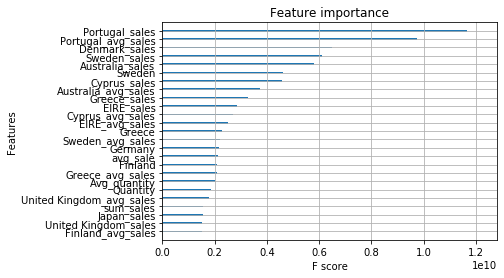

In [55]:
xgb.plot_importance(model, importance_type='gain', max_num_features=25, show_values=False)

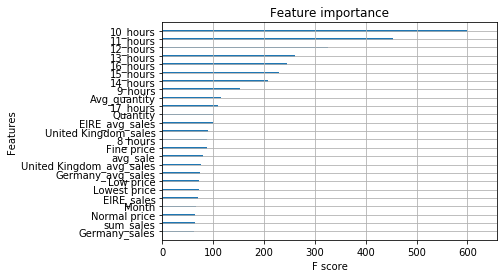

In [56]:
xgb.plot_importance(model, max_num_features=25, show_values=False)

# Тест модели на датасете за следующий год.

In [57]:
retail_predict = pd.read_excel(r'D:\ML_Sets\online_retail_II.xlsx', sheet_name='Year 2010-2011')

In [58]:
retail_predict, features_for_demand = first_change(retail_predict)

In [59]:
retail_by_day_predict = create_features_for_demand(retail_predict, features_for_demand )    

In [60]:
retail_by_day['Predict'] = retail_by_day['sum_sales'].shift(-1)
retail_by_day.dropna(inplace=True)
X_pred =retail_by_day.drop(['Predict', 'Day'], axis=1)
y_pred =retail_by_day['Predict']

In [66]:
retail_by_day_predict.head()

,10_hours,11_hours,12_hours,13_hours,14_hours,15_hours,16_hours,17_hours,18_hours,19_hours,20_hours,6_hours,7_hours,8_hours,9_hours,Australia,Australia_avg_sales,Australia_sales,Austria,Austria_avg_sales,Austria_sales,Avg_quantity,Bahrain,Bahrain_avg_sales,Bahrain_sales,Belgium,Belgium_avg_sales,Belgium_sales,Brazil,Brazil_avg_sales,Brazil_sales,Canada,Canada_avg_sales,Canada_sales,Channel Islands,Channel Islands_avg_sales,Channel Islands_sales,Cyprus,Cyprus_avg_sales,Cyprus_sales,Czech Republic,Czech Republic_avg_sales,Czech Republic_sales,Day,Denmark,Denmark_avg_sales,Denmark_sales,EIRE,EIRE_avg_sales,EIRE_sales,European Community,European Community_avg_sales,European Community_sales,Fine price,Finland,Finland_avg_sales,Finland_sales,France,France_avg_sales,France_sales,Germany,Germany_avg_sales,Germany_sales,Greece,Greece_avg_sales,Greece_sales,High price,Iceland,Iceland_avg_sales,Iceland_sales,Israel,Israel_avg_sales,Israel_sales,Italy,Italy_avg_sales,Italy_sales,Japan,Japan_avg_sales,Japan_sales,Lebanon,Lebanon_avg_sales,Lebanon_sales,Lithuania,Lithuania_avg_sales,Lithuania_sales,Low price,Lowest price,Malta,Malta_avg_sales,Malta_sales,Month,Netherlands,Netherlands_avg_sales,Netherlands_sales,Normal price,Norway,Norway_avg_sales,Norway_sales,Poland,Poland_avg_sales,Poland_sales,Portugal,Portugal_avg_sales,Portugal_sales,Quantity,RSA,RSA_avg_sales,RSA_sales,Saudi Arabia,Saudi Arabia_avg_sales,Saudi Arabia_sales,Singapore,Singapore_avg_sales,Singapore_sales,Spain,Spain_avg_sales,Spain_sales,Sweden,Sweden_avg_sales,Sweden_sales,Switzerland,Switzerland_avg_sales,Switzerland_sales,USA,USA_avg_sales,USA_sales,United Arab Emirates,United Arab Emirates_avg_sales,United Arab Emirates_sales,United Kingdom,United Kingdom_avg_sales,United Kingdom_sales,Unspecified,Unspecified_avg_sales,Unspecified_sales,avg_sale,count_customers,day_of_week,nunique_products,sum_sales
0,121.0,368,421,267.0,197.0,185.0,159.0,49.0,0.0,0.0,0.0,0.0,0.0,45.0,150.0,1.0,564.807143,564.807143,0.0,0.0,0.0,247.690722,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-12-01,0.0,0.0,0.0,1.0,1546.405714,1546.405714,0.0,0.0,0.0,429,0.0,0.0,0.0,1.0,875.333684,875.333684,2.0,157.055714,314.111429,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,328,329,0.0,0.0,0.0,12,1.0,177.6,177.6,871,1.0,2604.723836,2604.723836,0.0,0.000,0.000,0.0,0.000000,0.000000,24026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,90,744.384546,66994.609136,0.0,0.0,0.0,775.330031,97,2,945,75207.013007
1,203.0,249,198,242.0,190.0,334.0,136.0,113.0,122.0,105.0,0.0,0.0,10.0,52.0,88.0,0.0,0.000000,0.000000,0.0,0.0,0.0,179.767241,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-12-02,0.0,0.0,0.0,2.0,7.500000,15.000000,0.0,0.0,0.0,420,0.0,0.0,0.0,0.0,0.000000,0.000000,2.0,223.761364,447.522727,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,343,416,0.0,0.0,0.0,12,0.0,0.0,0.0,855,0.0,0.000000,0.000000,0.0,0.000,0.000,0.0,0.000000,0.000000,20853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,112,594.694908,66605.829744,0.0,0.0,0.0,578.334633,116,3,921,67086.817405
2,109.0,123,224,72.0,250.0,127.0,56.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.000000,0.000000,0.0,0.0,0.0,209.654545,0.0,0.0,0.0,1.0,928.150909,928.150909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-12-03,0.0,0.0,0.0,2.0,4888.969595,9777.939189,0.0,0.0,0.0,241,0.0,0.0,0.0,2.0,302.754286,605.508571,3.0,188.955556,566.866667,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,496.565217,496.565217,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,176,189,0.0,0.0,0.0,12,0.0,0.0,0.0,498,0.0,0.000000,0.000000,1.0,332.325,332.325,1.0,110.933333,110.933333,11531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,628.0,62

In [61]:
y_predict = model.predict(xgb.DMatrix(X_pred))

sales_df = pd.DataFrame((y_predict, y_pred)).T
sales_df.columns = ['Predict_Sales', 'Real_Sales']

Видно, что с предсказанием спроса на день модель справляется. Даже предсказывает аномальные пики, но не всегда успешно. В целом, можно высчитать коофицент ошибки и домножать на него аномальное предсказание. 

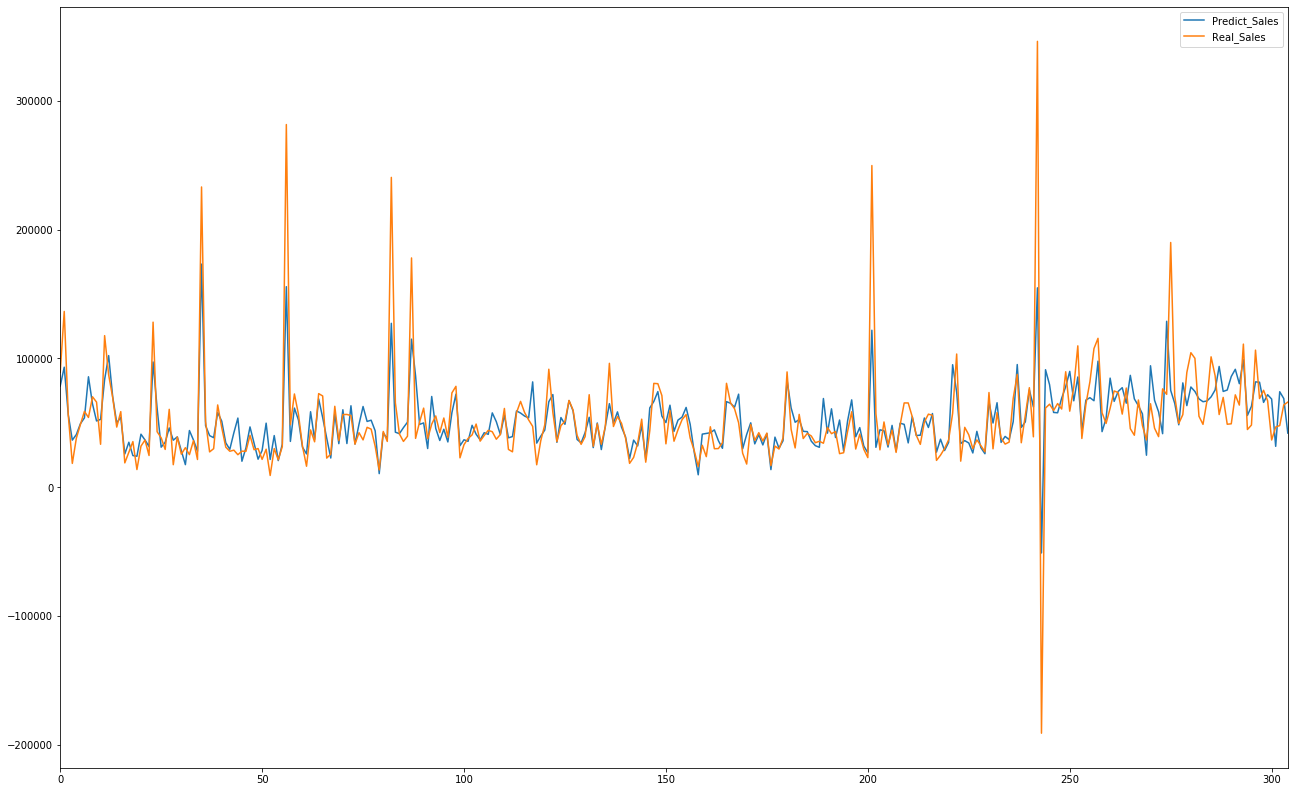

In [69]:
sales_df.plot(figsize=(22,14))